In [38]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils.np_utils import to_categorical

In [42]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Valid', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(519, activation="relu"))  # [[521,0.9962,70],[519,0.9969,51]
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=["accuracy"])

annealer = ReduceLROnPlateau(monitor='val_acc', patience=1, verbose=2, factor=0.5, min_lr=0.00001) #patience=2

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)  # , preprocessing_function=random_add_or_erase_spot)

(42000, 785)
{0: 4132, 1: 4684, 2: 4177, 3: 4351, 4: 4072, 5: 3795, 6: 4137, 7: 4401, 8: 4063, 9: 4188}
Epoch 1/30
590/590 [==============================] - 94s 160ms/step - loss: 0.0180 - acc: 0.9947 - val_loss: 0.0213 - val_acc: 0.9934
Epoch 2/30
590/590 [==============================] - 95s 160ms/step - loss: 0.0165 - acc: 0.9946 - val_loss: 0.0228 - val_acc: 0.9938
Epoch 3/30
590/590 [==============================] - 94s 160ms/step - loss: 0.0177 - acc: 0.9948 - val_loss: 0.0230 - val_acc: 0.9927

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 4/30
590/590 [==============================] - 96s 162ms/step - loss: 0.0174 - acc: 0.9945 - val_loss: 0.0234 - val_acc: 0.9931

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-07.
Epoch 5/30
590/590 [==============================] - 95s 161ms/step - loss: 0.0180 - acc: 0.9948 - val_loss: 0.0196 - val_acc: 0.9943
Epoch 6/30
590/590 [==============================] - 95s 160ms/step - loss: 0.0178 - acc: 

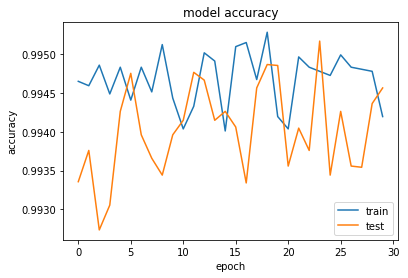

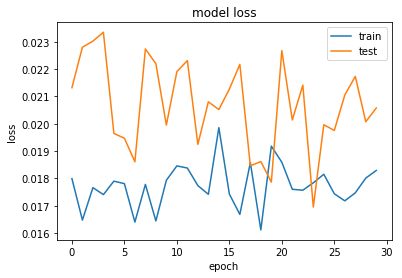

(28000, 784)
Base model scores:
[[411   0   0   0   0   0   0   0   0   0]
 [  0 483   0   0   1   0   0   0   1   0]
 [  0   0 402   0   0   0   0   0   1   0]
 [  0   0   0 416   0   0   0   0   2   0]
 [  0   0   0   0 459   0   1   0   0   1]
 [  0   0   0   2   0 367   1   0   2   0]
 [  0   0   0   0   1   0 411   0   1   0]
 [  0   0   0   0   0   0   0 446   0   0]
 [  0   0   0   0   1   0   0   0 381   0]
 [  0   0   0   0   1   0   0   1   0 407]]


In [45]:
train = pd.read_csv("./train.csv")
print(train.shape)
y = train["label"]
X = train.drop("label", axis = 1)
print(y.value_counts().to_dict())
y = to_categorical(y, num_classes = 10)
del train
X = X / 255.0
X = X.values.reshape(-1,28,28,1)
seed=2
train_index, valid_index = ShuffleSplit(n_splits=1,
                                        train_size=0.9,
                                        test_size=None,
                                        random_state=seed).split(X).__next__()
x_train = X[train_index]
Y_train = y[train_index]
x_test = X[valid_index]
Y_test = y[valid_index]
epochs = 30
batch_size = 64
validation_steps = 10000
# Start training
train_generator = datagen.flow(x_train, Y_train, batch_size=batch_size)
test_generator = datagen.flow(x_test, Y_test, batch_size=batch_size)

history = model.fit_generator(train_generator,
                    steps_per_epoch=x_train.shape[0]//batch_size,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps//batch_size,
                    callbacks=[annealer])

score = model.evaluate(x_test, Y_test)
print('Test accuracy: ', score[1])

# Saving Model for future API
model.save('Digits-1.3.0.h5')
print("Saved model to disk")

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Model predict
test = pd.read_csv("./test.csv")
print(test.shape)
test = test / 255
test = test.values.reshape(-1, 28, 28, 1)
p = np.argmax(model.predict(test), axis=1)

print('Base model scores:')
valid_loss, valid_acc = model.evaluate(x_test, Y_test, verbose=0)
valid_p = np.argmax(model.predict(x_test), axis=1)
target = np.argmax(Y_test, axis=1)
cm = confusion_matrix(target, valid_p)
print(cm)

## Preparing file for submission
submission = pd.DataFrame(pd.Series(range(1, p.shape[0] + 1), name='ImageId'))
submission['Label'] = p
filename="keras-cnn-{0}.csv".format(str(int(score[1]*10000)))
submission.to_csv(filename, index=False)